# IMPORTING LIBRARIES

In [18]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

ImportError: This version of TensorFlow Probability requires TensorFlow version >= 2.13; Detected an installation of version 2.10.0. Please upgrade TensorFlow to proceed.

# IMPORTING MNIST DATA

In [5]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.mnist.load_data()

# VISUALIZING THE DATA

In [7]:
X_train.shape

(60000, 28, 28)

/tmp/ipykernel_10980/2495820623.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


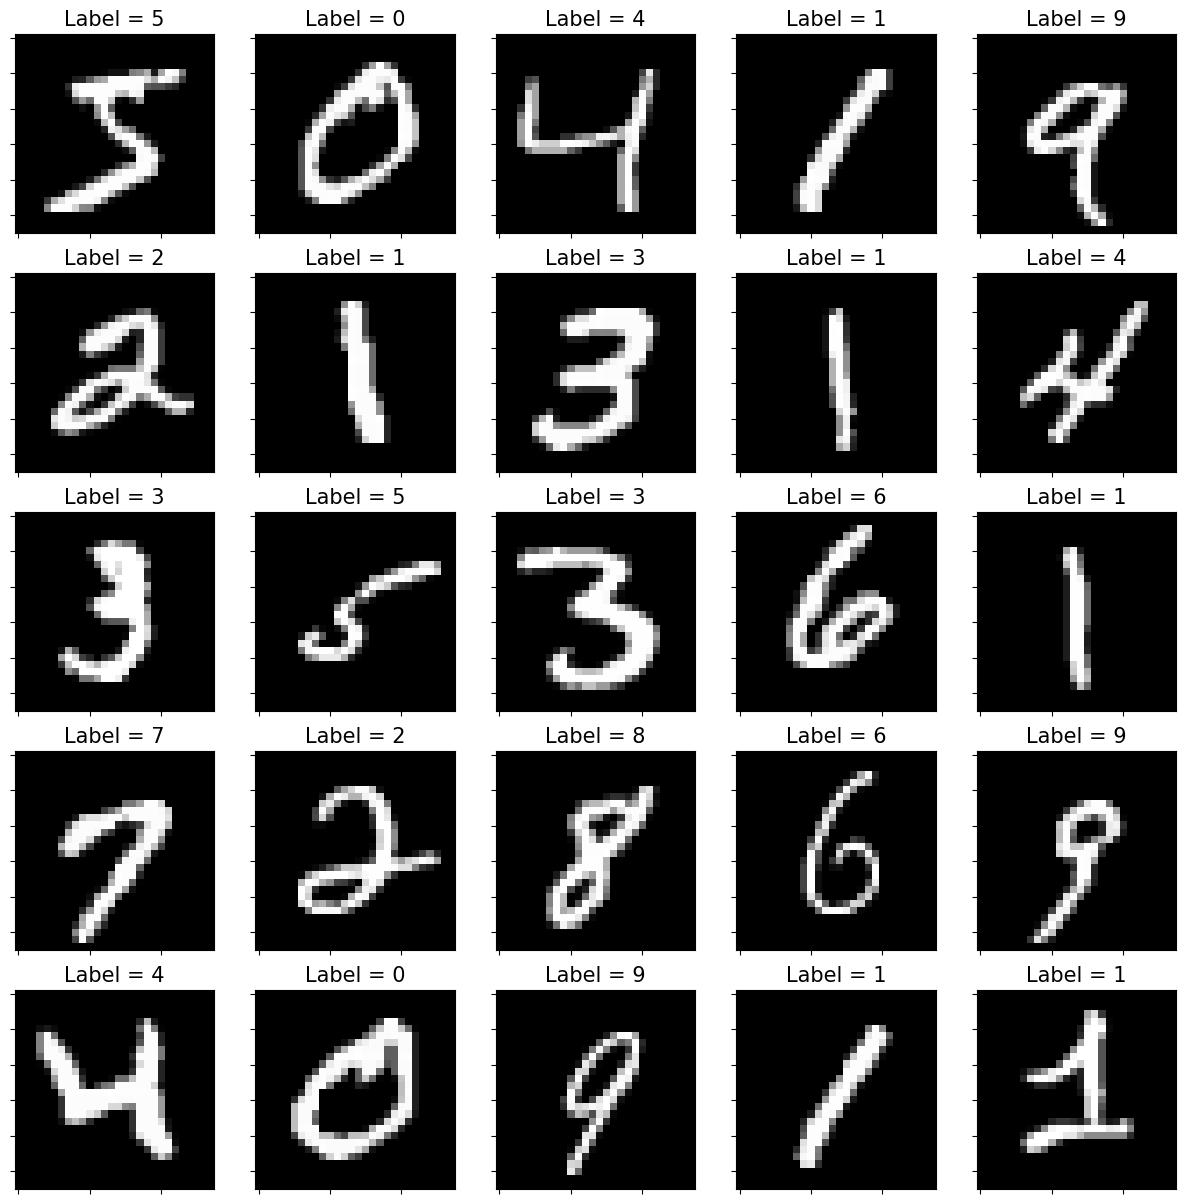

In [15]:
fig,axes = plt.subplots(nrows=5,ncols=5,figsize=(15,15))
row =0
col = 0
for i in range(25):
    if col in [4,9,14,19]:
        axes[row][col].imshow(X_train[i],cmap="gray")
        axes[row][col].set_title("Label = "+str(y_train[i]),fontsize=15)
        axes[row][col].set_xticklabels([])
        axes[row][col].set_yticklabels([])
        row+=1
        col = 0
    else:
        axes[row][col].imshow(X_train[i],cmap="gray")
        axes[row][col].set_title("Label = "+str(y_train[i]),fontsize=15)
        axes[row][col].set_xticklabels([])
        axes[row][col].set_yticklabels([])
        col+=1
fig.show()

# SHUFFLING AND MAKING DATASET

In [40]:
def make_dataset(X_train):
    images = X_train.reshape((-1,28,28,1))/255
    return np.where(images>0.5,1.0,0.0).astype(np.float32)

In [41]:
train_images = make_dataset(X_train)
test_images = make_dataset(X_test)

In [47]:
def make_tensor_data(data,shuffle_size,batch_size):
    return tf.data.Dataset.from_tensor_slices(data).shuffle(shuffle_size).batch(batch_size)

In [48]:
train_dataset = make_tensor_data(train_images,train_images.shape[0],32)
test_dataset = make_tensor_data(test_images,test_images.shape[0],32)

2023-09-07 18:58:21.762277: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-07 18:58:21.762332: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hari-HP-Pavilion-Gaming-Laptop-15-dk1xxx): /proc/driver/nvidia/version does not exist
2023-09-07 18:58:22.128131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# MODEL BUILDING

## ENCODER BUILDING

In [56]:
class encoder(tf.keras.Model):
    def __init__(self,latent_dim,img_shape,conv_info = {}):
        super().__init__(self)
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential()
        self.encoder.add(tf.keras.layers.InputLayer(input_shape = img_shape))
        if conv_info == []:
            for filters,kernel in  {32:3,64:3}.items():
                self.encoder.add(tf.keras.layers.Conv2D(filters,kernel,strides=(2,2),activation="relu"))
        else:
            for filters,kernel in conv_info.items():
                self.encoder.add(tf.keras.layers.Conv2D(filters,kernel,strides=(2,2),activation="relu"))
        self.encoder.add(tf.keras.layers.Flatten())
        self.encoder.add(tf.keras.layers.Dense(self.latent_dim+self.latent_dim))

In [57]:
encoder = encoder(7,(28,28,1))